In [11]:
import pandas as pd
import yfinance as yf
import pandas_market_calendars as mcal
import yfinance as yf
from datetime import datetime
from sklearn.linear_model import LinearRegression

start_date = '2012-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')
holding_period=20
# Fetch VOO data
voo = yf.Ticker("VOO")
df_voo= voo.history(start=start_date, end=end_date).reset_index()
df_voo['Date']=pd.to_datetime(df_voo['Date']).dt.date


In [13]:
df_voo['Volume'].isnull().sum()

0

In [173]:
import numpy as np
def donchian(df):
    max_high=df['High'].max()
    min_low=df['Low'].min()
    return (max_high+min_low)/2
def SMA(df):
    try:
        return df['Close'].mean()
    except:
        return df['Adj Close'].mean()
def Delta(df,donch,sma):
    try:
        return df['Close'] - ( (donch + sma) / 2 )
    except:
        return df['Adj Close'] - ( (donch + sma) / 2 )

def get_TTM(hist):
    #hist=hist.head(241)
    try:
        hist=hist.dropna(subset='Close')
    except:
        hist=hist.dropna(subset='Adj Close')
    hist=hist.sort_values(by='Date')
    len(hist)
    df=hist.iloc[:20].copy()
    donch=donchian(df)
    sma=SMA(df)
    deltas=Delta(df,donch,sma)
    
    lr=LinearRegression()
    X=np.array([i for i in range(20)]).reshape(-1,1)
    print(len(deltas),len(df),len(X))
    lr.fit(X,deltas)
    df['values']=lr.predict(X)
    list_of_values=[]
    metrics=[]
    smas=[]
    donches=[]
    first=True
    for i in range(20,len(hist)+1):
        df=hist.iloc[i-20:i]
        donch=donchian(df)
        sma=SMA(df)
        
        deltas=Delta(df,donch,sma)
        lr.fit(X,deltas)
        values=lr.predict(X)
        if first:
            first=False
            list_of_values=np.append(list_of_values,values)   
            metrics+=[(donch+sma)/2 for _ in range(20)]
            smas+=[sma for _ in range(20)]
            donches+=[donch for _ in range(20)]
        else:  
            values=values[-1]
            list_of_values=np.append(list_of_values,values)
            metrics.append((donch+sma)/2)
            smas.append(sma)
            donches.append(donch)
    hist['values']=list_of_values
    hist.head(10)
    hist['metric']=metrics
    hist['donch']=donches
    hist['sma']=smas
    return hist

In [174]:
df_voo=get_TTM(df_voo)
df_voo=df_voo.rename(columns={'values':'TTM_voo'})
df_voo.head()

20 20 20


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains,TTM_voo,metric,donch,sma
0,2012-01-03,93.068785,93.514622,92.829941,92.829941,163250,0.0,0.0,0.0,-1.751451,94.661462,94.613294,94.709631
1,2012-01-04,92.702548,93.084692,92.320398,92.989159,448450,0.0,0.0,0.0,-1.562018,94.661462,94.613294,94.709631
2,2012-01-05,92.575175,93.387241,92.097492,93.291702,253500,0.0,0.0,0.0,-1.372584,94.661462,94.613294,94.709631
3,2012-01-06,93.387250,93.387250,92.734416,93.100639,166900,0.0,0.0,0.0,-1.183150,94.661462,94.613294,94.709631
4,2012-01-09,93.259847,93.339460,92.782164,93.243927,177000,0.0,0.0,0.0,-0.993717,94.661462,94.613294,94.709631


In [175]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_TTM(hist,col='TTM_voo'):
    fig,ax =plt.subplots(2,figsize=(18,16))
    ax[1].bar(hist.index,hist[col], label='TTM')
    ax[0].set_ylabel('Close')
    ax[0].plot(hist.index,hist['Close'], label='Close')
    ax[0].plot(hist.index,hist['metric'],label='Average Metric')
    ax[0].plot(hist.index,hist['donch'], label='Donch')
    ax[0].plot(hist.index,hist['sma'],label='SMA')
                    
                         
    ax[0].legend()
    plt.legend()     
    plt.tight_layout()
    plt.savefig('TTM_Squeeze_msft.png')
    plt.show()
plot_ttm=False
if plot_ttm:
    plot_TTM(df_voo)

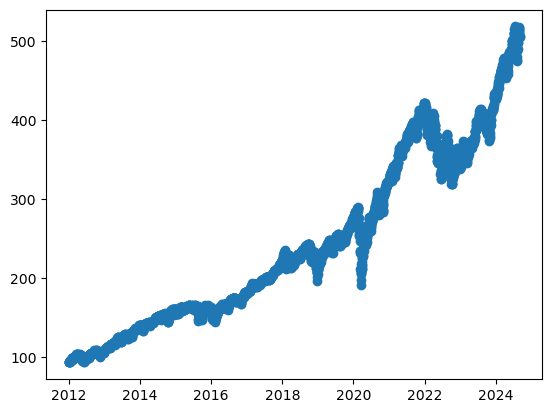

In [176]:
import matplotlib.pyplot as plt
plot_market=True
if plot_market:
    fig, ax=plt.subplots()
    ax.scatter(x='Date',y='Close',data=df_voo.reset_index())
    plt.show()

In [177]:
def mark_downturn(data, window=60, threshold=0.1):
    rolling_max = data['Close'].rolling(window=window, min_periods=1).max()
    drawdown = (data['Close'] - rolling_max) / rolling_max
    return (drawdown < -threshold) & (drawdown.shift(1) >= -threshold)


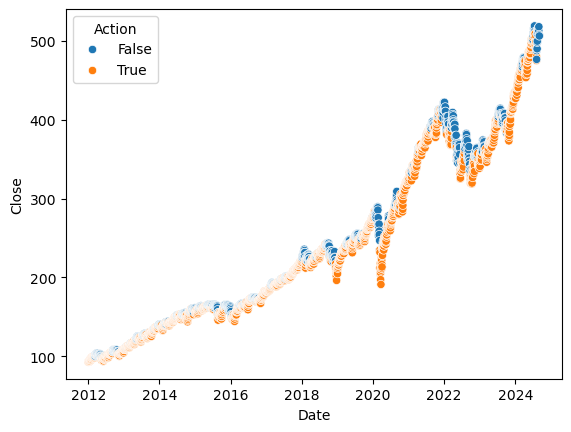

In [178]:
import matplotlib.pyplot as plt
import seaborn as sns
df_voo['Future_Close'] = df_voo['Close'].shift(-1*holding_period)  # Shift the closing price 20 days into the future
df_voo['Action'] = df_voo['Future_Close'] > df_voo['Close']  
df_voo[['Action','Close','Future_Close']].head(20)
fig, ax=plt.subplots()
sns.scatterplot(x='Date',y='Close',data=df_voo.reset_index(),hue='Action',ax=ax)
plt.show()



In [179]:
df_voo['Action'].value_counts()

Action
True     2177
False    1011
Name: count, dtype: int64

In [180]:
import numpy as np
def find_local_maxima(data, window_size=5):
    maxima = []
    for i in range(window_size, len(data) - window_size):
        window = data[i-window_size:i+window_size+1]
        if data[i] == max(window):
            maxima.append(i)
    return maxima

import pandas as pd
import numpy as np

def is_n_day_high(df, n=20, price_column='Close'):
    """
    Determines if the closing price is at a maximum for the last n days,
    only considering past data for each date.
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing price data
    n (int): Number of days to look back (default is 20)
    price_column (str): Name of the column containing closing prices (default is 'Close')
    
    Returns:
    pandas.Series: Boolean series where True indicates a n-day high
    """
    # Ensure the DataFrame is sorted by date in ascending order
    df = df.sort_values(by='Date')
    
    # Initialize the result series
    is_high = pd.Series(False, index=df.index)
    
    # Iterate through the DataFrame
    for i in range(n, len(df)):
        # Get the last n days of prices (including the current day)
        last_n_days = df[price_column].iloc[i-n+1:i+1]
        
        # Check if the current day's price is the maximum
        if df[price_column].iloc[i] == last_n_days.max():
            is_high.iloc[i] = True
    
    return is_high

# Example usage:
# Assuming 'df' is your DataFrame with a DatetimeIndex and 'Close' column

# df['is_20_day_high'] = is_n_day_high(df)
# df['is_50_day_high'] = is_n_day_high(df, n=50)

# Example usage:
# Assuming 'df' is your DataFrame with a DatetimeIndex and 'Close' column

# df['is_20_day_high'] = is_n_day_high(df)
# df['is_50_day_high'] = is_n_day_high(df, n=50)


# Assuming df_voo is your DataFrame with a 'Close' column
#close_prices = df_voo['Close'].values
#maxima_indices = find_local_maxima(close_prices, window_size=20)

# Mark the maxima in your DataFrame
#df_voo['Is_Local_Max'] = False
#df_voo.loc[maxima_indices, 'Is_Local_Max'] = True

# Print the dates and prices of local maxima
#print(df_voo[df_voo['Is_Local_Max']][['Date', 'Close']])
df_voo['Is_Local_Max']=is_n_day_high(df_voo,n=20)

In [181]:
df_voo.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains,TTM_voo,metric,donch,sma,Future_Close,Action,Is_Local_Max
0,2012-01-03,93.068785,93.514622,92.829941,92.829941,163250,0.0,0.0,0.0,-1.751451,94.661462,94.613294,94.709631,96.476250,True,False
1,2012-01-04,92.702548,93.084692,92.320398,92.989159,448450,0.0,0.0,0.0,-1.562018,94.661462,94.613294,94.709631,96.667343,True,False
2,2012-01-05,92.575175,93.387241,92.097492,93.291702,253500,0.0,0.0,0.0,-1.372584,94.661462,94.613294,94.709631,98.036720,True,False
3,2012-01-06,93.387250,93.387250,92.734416,93.100639,166900,0.0,0.0,0.0,-1.183150,94.661462,94.613294,94.709631,97.893402,True,False
4,2012-01-09,93.259847,93.339460,92.782164,93.243927,177000,0.0,0.0,0.0,-0.993717,94.661462,94.613294,94.709631,98.195915,True,False


In [182]:
df_voo.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends',
       'Stock Splits', 'Capital Gains', 'TTM_voo', 'metric', 'donch', 'sma',
       'Future_Close', 'Action', 'Is_Local_Max'],
      dtype='object')

In [183]:
df_voo=df_voo.reset_index()
df_voo['Date']=pd.to_datetime(df_voo['Date'])
df_voo['Month']=df_voo['Date'].dt.month
df_voo['Year']=df_voo['Date'].dt.year

In [184]:
def is_decreasing_market2(df,period=20):
    df=df.sort_values(by='Date')
    for i in range(period):
        df[f'is_max_lag{i}']=df['Is_Local_Max'].shift(i)
        df[f'Close_Lag{i}']=df['Close'].shift(i)
    cols=[col for col in df.columns if 'is_max_lag' in col]
    df['Count_Max']=df[cols].sum(axis=1)
    df['isDecreasing']=df['Count_Max'].apply(lambda x: True if x<int(0.3*period) else False)
    df['isDecreasing']=df.apply(lambda x: False if sum([x[f'is_max_lag{i}'] for i in range(int(0.3*period))])>int(0.3*period)-2 else x['isDecreasing'],axis=1)
    #df['isDecreasing']=df[[col for col in df.columns if 'Close_Lag' in col]].apply(LinearModel)
    return df
import pandas as pd
import numpy as np
from scipy import stats

def is_decreasing_market(df, period=20, method='moving_average', threshold=0.05):
    """
    Identify decreasing market conditions using various methods.
    
    :param df: DataFrame with 'Date' and 'Close' columns
    :param period: Number of days to consider
    :param method: 'moving_average', 'linear_regression', 'percent_change', or 'drawdown'
    :param threshold: Threshold for considering market as decreasing
    :return: DataFrame with 'isDecreasing' column
    """
    df = df.sort_values(by='Date').copy()
    
    if method == 'moving_average':
        df['MA'] = df['Close'].rolling(window=period).mean()
        df['isDecreasing'] = df['Close'] < df['MA']
    
    elif method == 'linear_regression':
        def rolling_regression(x):
            return stats.linregress(range(len(x)), x)[0]
        df['Slope'] = df['Close'].rolling(window=period).apply(rolling_regression)
        df['isDecreasing'] = df['Slope'] < 0
    
    elif method == 'percent_change':
        df['PercentChange'] = df['Close'].pct_change(periods=period)
        df['isDecreasing'] = df['PercentChange'] < -threshold
    
    elif method == 'drawdown':
        df['Rolling_Max'] = df['Close'].rolling(window=period, min_periods=1).max()
        df['Drawdown'] = (df['Close'] - df['Rolling_Max']) / df['Rolling_Max']
        df['isDecreasing'] = df['Drawdown'] < -threshold
    
    else:
        raise ValueError("Invalid method. Choose 'moving_average', 'linear_regression', 'percent_change', or 'drawdown'.")
    
    return df

# Example usage:
df_voo = is_decreasing_market(df_voo, period=20, method='moving_average', threshold=0.10)



    
    


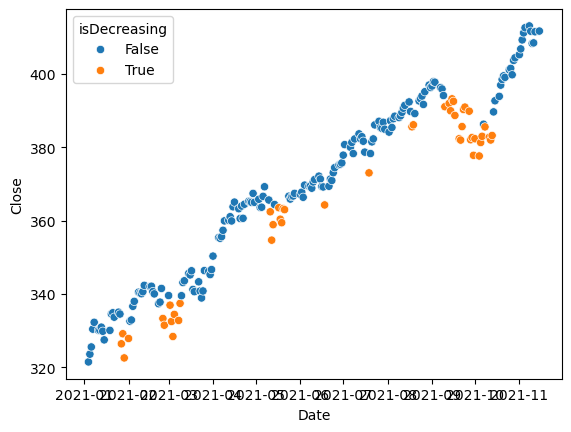

In [103]:
data=df_voo[(df_voo['Date'].dt.year>=2021)&(df_voo['Date'].dt.year<2022)].iloc[:220]

fig, ax=plt.subplots()
sns.scatterplot(x='Date',y='Close',data=data,hue='isDecreasing',ax=ax)
#ax.scatter(x='Date',y='lr_value', color='red',data=data)
plt.show()

In [27]:
df_test.iloc[30:50]

NameError: name 'df_test' is not defined

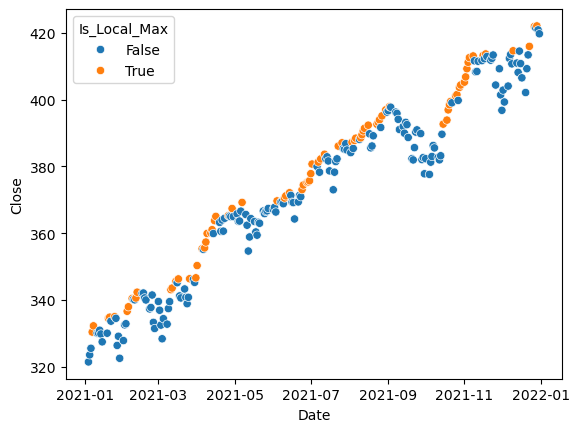

In [105]:
data=df_voo[(df_voo['Date'].dt.year>=2021)&(df_voo['Date'].dt.year<2022)]
fig, ax=plt.subplots()
sns.scatterplot(x='Date',y='Close',data=data,hue='Is_Local_Max',ax=ax)
plt.show()

In [187]:
import yfinance as yf
import pandas as pd

# Download data for Consumer Discretionary and Information Technology ETFs
xly = yf.download('XLY', start=start_date, end=end_date).reset_index()
xlk = yf.download('XLK', start=start_date, end=end_date).reset_index()


df_voo=df_voo.reset_index()
# Assume df_voo is your existing DataFrame
#df_voo['Consumer_Discretionary'] = xly['Close']
#df_voo['IT'] = xlk['Close']
xly['Date'] = pd.to_datetime(xly['Date'])
xlk['Date'] = pd.to_datetime(xlk['Date'])
df_voo['Date'] = pd.to_datetime(df_voo['Date'])
xlk=get_TTM(xlk)
xlk=xlk.rename(columns={'values':'TTM_xlk'})
xly=get_TTM(xly)

xly=xly.rename(columns={'values':'TTM_xly'})
xly=xly[['Date','Adj Close','Volume','TTM_xly']]
xlk=xlk[['Date','Adj Close','Volume','TTM_xlk']]

xlk['Is_Local_Max_xlk']=is_n_day_high(xlk, price_column='Adj Close',n=30)
xly['Is_Local_Max_xly']=is_n_day_high(xly, price_column='Adj Close',n=30)
xly=xly.rename(columns={'Adj Close':'Adj Close_xly','Volume':'Volume_xly'})
xlk=xlk.rename(columns={'Adj Close':'Adj Close_xlk','Volume':'Volume_xlk'})
joined=pd.merge(df_voo,xly,on='Date')
joined=pd.merge(joined,xlk,on='Date')


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


20 20 20
20 20 20


In [189]:
import pandas_datareader as pdr
from datetime import datetime

start_date = datetime(2012, 1, 1)
end_date = datetime.now()

# Fetch the federal funds rate data
fed_funds_rate = pdr.get_data_fred('FEDFUNDS', start=start_date, end=end_date)


# Fetch the unemployment rate data
unemployment_rate = pdr.get_data_fred('UNRATE', start=start_date, end=end_date)

print(unemployment_rate.head())
print("\nMost recent unemployment rate:")
print(unemployment_rate.tail(1))

fed_funds_rate=fed_funds_rate.reset_index()
fed_funds_rate['DATE']=pd.to_datetime(fed_funds_rate['DATE'])
unemployment_rate=unemployment_rate.reset_index()
unemployment_rate['DATE']=pd.to_datetime(unemployment_rate['DATE'])
fed_funds_rate['Month']=fed_funds_rate['DATE'].dt.month
fed_funds_rate['Year']=fed_funds_rate['DATE'].dt.year
unemployment_rate['Month']=unemployment_rate['DATE'].dt.month
unemployment_rate['Year']=unemployment_rate['DATE'].dt.year
joined=pd.merge(joined,fed_funds_rate,on=['Month','Year'])
joined=pd.merge(joined,unemployment_rate,on=['Month','Year'])

            UNRATE
DATE              
2012-01-01     8.3
2012-02-01     8.3
2012-03-01     8.2
2012-04-01     8.2
2012-05-01     8.2

Most recent unemployment rate:
            UNRATE
DATE              
2024-07-01     4.3


In [114]:
joined

,level_0,index,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,...,TTM_xly,Is_Local_Max_xly,Adj Close_xlk,Volume_xlk,TTM_xlk,Is_Local_Max_xlk,DATE_x,FEDFUNDS,DATE_y,UNRATE
0,0,0,2012-01-03,93.068785,93.514622,92.829941,92.829941,163250,0.0,0.0,...,-0.969179,False,21.661150,26839900,-0.699072,False,2012-01-01,0.08,2012-01-01,8.3
1,1,1,2012-01-04,92.702548,93.084692,92.320398,92.989159,448450,0.0,0.0,...,-0.859502,False,21.719900,4744300,-0.624485,False,2012-01-01,0.08,2012-01-01,8.3
2,2,2,2012-01-05,92.575175,93.387241,92.097492,93.291702,253500,0.0,0.0,...,-0.749825,False,21.787037,6756900,-0.549899,False,2012-01-01,0.08,2012-01-01,8.3
3,3,3,2012-01-06,93.387250,93.387250,92.734416,93.100639,166900,0.0,0.0,...,-0.640149,False,21.795431,4989200,-0.475312,False,2012-01-01,0.08,2012-01-01,8.3
4,4,4,2012-01-09,93.259847,93.339460,92.782164,93.243927,177000,0.0,0.0,...,-0.530472,False,21.761860,4086600,-0.400726,False,2012-01-01,0.08,2012-01-01,8.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3159,3159,3159,2024-07-25,497.549988,503.140015,493.920013,494.779999,5646600,0.0,0.0,...,0.895861,False,213.570007,10579000,-3.624893,False,2024-07-01,5.33,2024-07-01,4.3
3160,3160,3160,2024-07-26,498.359985,502.890015,497.670013,500.329987,3636000,0.0,0.0,...,-0.420140,False,216.279999,5848900,-5.780857,False,2024-07-01,5.33,2024-07-01,4.3
3161,3161,3161,2024-07-29,501.820007,502.769989,498.769989,500.700012,3096200,0.0,0.0,...,-1.475926,False,215.320007,3671900,-7.962249,False,2024-07-01,5.33,2024-07-01,4.3
3162,3162,3162,2024-07-30,502.049988,503.010010,494.920013,498.079987,3817800,0.0,0.0,...,-2.666318,False,209.910004,5347300,-10.103498,False,2024-07-01,5.33,2024-07-01,4.3


In [191]:
joined=joined.drop(columns=['DATE_x','DATE_y'])

In [1277]:
joined[['Close','Date']].to_csv('Check_Check.csv',index=False)

In [193]:
import pandas_datareader as pdr
from datetime import datetime

start_date = datetime(2012, 1, 1)
end_date = datetime.now()

# Fetch Consumer Price Index (CPI) data
cpi = pdr.get_data_fred('CPIAUCSL', start=start_date, end=end_date)

# Fetch Consumer Confidence Index data
cci = pdr.get_data_fred('CSCICP03USM665S', start=start_date, end=end_date)

print("Consumer Price Index (CPI):")
print(cpi.tail())
print("\nConsumer Confidence Index:")
print(cci.tail())

# Optionally, merge the two datasets
merged_data = cpi.merge(cci, left_index=True, right_index=True, how='outer')
merged_data.columns = ['CPI', 'Consumer_Confidence']

merged_data=merged_data.reset_index()
merged_data['Month']=merged_data['DATE'].dt.month
merged_data['Year']=merged_data['DATE'].dt.year
joined=pd.merge(joined,merged_data, on=['Month','Year'])


Consumer Price Index (CPI):
            CPIAUCSL
DATE                
2024-03-01   312.230
2024-04-01   313.207
2024-05-01   313.225
2024-06-01   313.049
2024-07-01   313.534

Consumer Confidence Index:
            CSCICP03USM665S
DATE                       
2023-09-01         97.74630
2023-10-01         97.51254
2023-11-01         97.56221
2023-12-01         98.10970
2024-01-01         98.91297


In [195]:
for item in joined.columns:
    print(item)

level_0
index
Date
Open
High
Low
Close
Volume
Dividends
Stock Splits
Capital Gains
TTM_voo
metric
donch
sma
Future_Close
Action
Is_Local_Max
Month
Year
MA
isDecreasing
Adj Close_xly
Volume_xly
TTM_xly
Is_Local_Max_xly
Adj Close_xlk
Volume_xlk
TTM_xlk
Is_Local_Max_xlk
FEDFUNDS
UNRATE
DATE
CPI
Consumer_Confidence


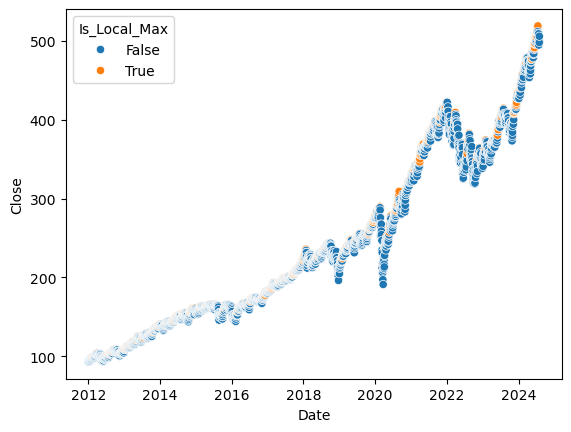

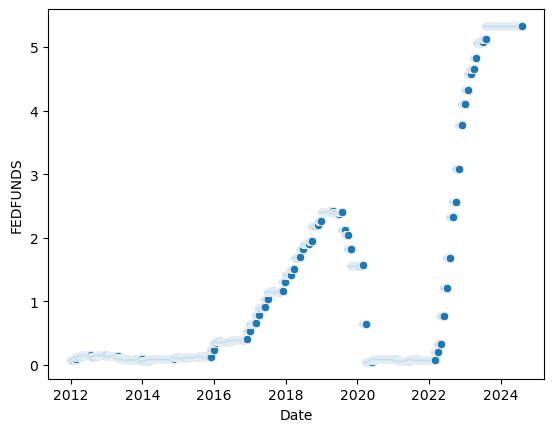

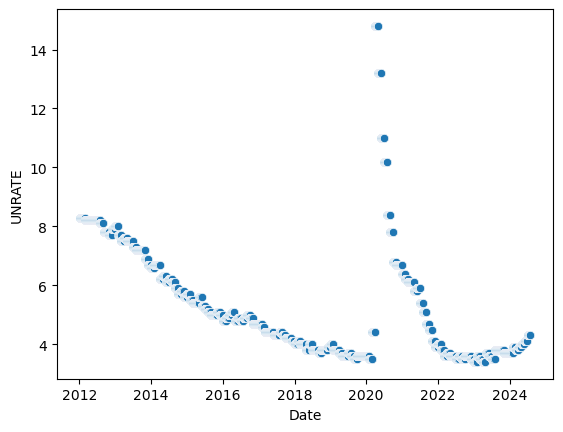

In [272]:
import seaborn as sns
fig, ax=plt.subplots()
sns.scatterplot(x='Date',y='Close',data=joined,hue='Is_Local_Max',ax=ax)

fig, ax2=plt.subplots()
sns.scatterplot(x='Date',y='FEDFUNDS',data=joined,ax=ax2)
plt.show()

fig, ax3=plt.subplots()
sns.scatterplot(x='Date',y='UNRATE',data=joined,ax=ax3)
plt.show()

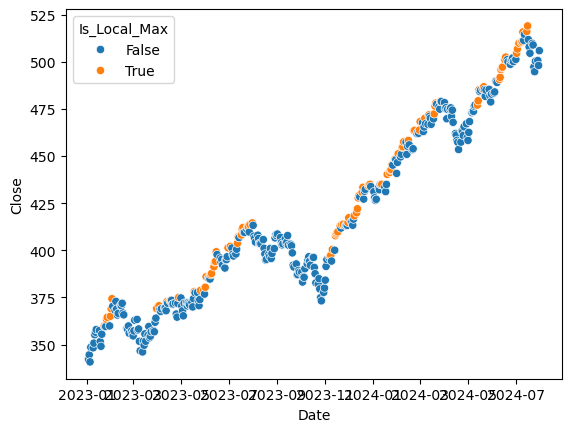

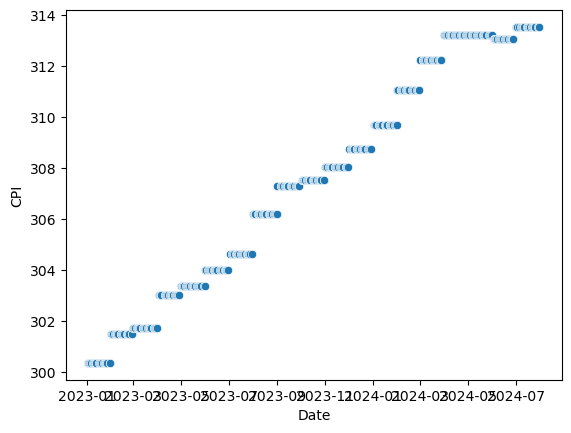

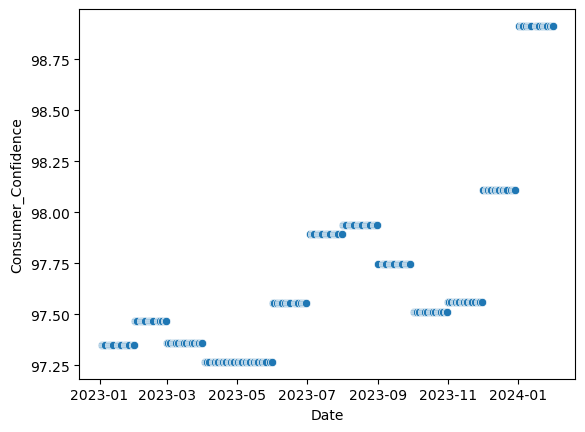

In [274]:
data=joined[joined['Year']>2022]
fig, ax=plt.subplots()
sns.scatterplot(x='Date',y='Close',data=data,hue='Is_Local_Max',ax=ax)

fig, ax2=plt.subplots()
sns.scatterplot(x='Date',y='CPI',data=data,ax=ax2)
plt.show()

fig, ax3=plt.subplots()
sns.scatterplot(x='Date',y='Consumer_Confidence',data=data,ax=ax3)
plt.show()

In [135]:
len(joined)

3164

In [197]:
import pandas as pd

# Assuming 'joined' is your DataFrame with the necessary columns
cols = ['Close', 'Volume', 'Adj Close_xly', 'Volume_xly', 'Adj Close_xlk', 'Volume_xlk']

# Calculate percent change for each column and create new columns for the percent change
for col in cols:
    joined[f'{col}_pct_change'] = joined[col].pct_change() * 100  # Multiply by 100 to convert to percentage

# Create lagged features for the last 20 days of percent changes
for col in cols:
    for i in range(1, 21):  # Start from 1 to 20
        joined[f'{col}_pct_change_lag{i}'] = joined[f'{col}_pct_change'].shift(i)
cols2=['TTM_voo','TTM_xlk','TTM_xly']
for col in cols2:
    joined[f'{col}_pct_change'] = joined[col].pct_change() * 100  # Multiply by 100 to convert to percentage

# Create lagged features for the last 20 days of percent changes
for col in cols2:
    for i in range(1, 14):  # Start from 1 to 20
        joined[f'{col}_pct_change_lag{i}'] = joined[f'{col}_pct_change'].shift(i)
        joined[f'{col}_raw_lag{i}']=joined[col].shift(i)
import numpy as np

cols3 = ['Is_Local_Max', 'Is_Local_Max_xlk', 'Is_Local_Max_xly']
for col in cols3:
    for i in range(1, 20):
        lagged_col = f'{col}_lag{i}'
        joined[lagged_col] = joined[col].shift(i)
        # Fill NaN values with False and convert to boolean
        joined[lagged_col] = joined[lagged_col].fillna(False).astype(bool)

# Verify the dtypes after the operation
print(joined[[col for col in joined.columns if col.startswith('Is_Local_Max')]].dtypes)



/var/folders/y_/zdr3xmx13qz3pq6ct9kglm7h0000gn/T/ipykernel_71290/2492549250.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  joined[f'{col}_pct_change_lag{i}'] = joined[f'{col}_pct_change'].shift(i)
/var/folders/y_/zdr3xmx13qz3pq6ct9kglm7h0000gn/T/ipykernel_71290/2492549250.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  joined[f'{col}_pct_change_lag{i}'] = joined[f'{col}_pct_change'].shift(i)
/var/folders/y_/zdr3xmx13qz3pq6ct9kglm7h0000gn/T/ipykernel_71290/2492549250.py:13: PerformanceWarning: DataFrame is highly fragm

Is_Local_Max              bool
Is_Local_Max_xly          bool
Is_Local_Max_xlk          bool
Is_Local_Max_lag1         bool
Is_Local_Max_lag2         bool
Is_Local_Max_lag3         bool
Is_Local_Max_lag4         bool
Is_Local_Max_lag5         bool
Is_Local_Max_lag6         bool
Is_Local_Max_lag7         bool
Is_Local_Max_lag8         bool
Is_Local_Max_lag9         bool
Is_Local_Max_lag10        bool
Is_Local_Max_lag11        bool
Is_Local_Max_lag12        bool
Is_Local_Max_lag13        bool
Is_Local_Max_lag14        bool
Is_Local_Max_lag15        bool
Is_Local_Max_lag16        bool
Is_Local_Max_lag17        bool
Is_Local_Max_lag18        bool
Is_Local_Max_lag19        bool
Is_Local_Max_xlk_lag1     bool
Is_Local_Max_xlk_lag2     bool
Is_Local_Max_xlk_lag3     bool
Is_Local_Max_xlk_lag4     bool
Is_Local_Max_xlk_lag5     bool
Is_Local_Max_xlk_lag6     bool
Is_Local_Max_xlk_lag7     bool
Is_Local_Max_xlk_lag8     bool
Is_Local_Max_xlk_lag9     bool
Is_Local_Max_xlk_lag10    bool
Is_Local

/var/folders/y_/zdr3xmx13qz3pq6ct9kglm7h0000gn/T/ipykernel_71290/2492549250.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  joined[lagged_col] = joined[col].shift(i)
/var/folders/y_/zdr3xmx13qz3pq6ct9kglm7h0000gn/T/ipykernel_71290/2492549250.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  joined[lagged_col] = joined[col].shift(i)
/var/folders/y_/zdr3xmx13qz3pq6ct9kglm7h0000gn/T/ipykernel_71290/2492549250.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

In [199]:
# Assuming 'joined' is your DataFrame with the necessary columns
cols = ['UNRATE', 'FEDFUNDS', 'CPI']
agg_d={col:'first' for col in cols}
grouped=joined.groupby(['Month','Year']).agg(agg_d).reset_index()
grouped=grouped.sort_values(by=['Year','Month'])
for col in cols:
    # Calculate the percent change and create a new column
    grouped[f'{col}_pct_change'] = grouped[col].pct_change() * 100  # Multiply by 100 to convert to percentage

# Create lagged features for the last 2 days of percent changes
for col in cols:
    for i in range(1, 3):  # Create lagged features for 1 and 2 days
        grouped[f'{col}_pct_change_lag{i}'] = grouped[f'{col}_pct_change'].shift(i)
joined=pd.merge(joined,grouped,on=['Month','Year'])


In [201]:
joined


,level_0,index,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,...,CPI_y,UNRATE_pct_change,FEDFUNDS_pct_change,CPI_pct_change,UNRATE_pct_change_lag1,UNRATE_pct_change_lag2,FEDFUNDS_pct_change_lag1,FEDFUNDS_pct_change_lag2,CPI_pct_change_lag1,CPI_pct_change_lag2
0,0,0,2012-01-03,93.068785,93.514622,92.829941,92.829941,163250,0.0,0.0,...,227.842,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,2012-01-04,92.702548,93.084692,92.320398,92.989159,448450,0.0,0.0,...,227.842,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,2012-01-05,92.575175,93.387241,92.097492,93.291702,253500,0.0,0.0,...,227.842,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,2012-01-06,93.387250,93.387250,92.734416,93.100639,166900,0.0,0.0,...,227.842,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4,2012-01-09,93.259847,93.339460,92.782164,93.243927,177000,0.0,0.0,...,227.842,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3159,3159,3159,2024-07-25,497.549988,503.140015,493.920013,494.779999,5646600,0.0,0.0,...,313.534,4.878049,0.0,0.154928,2.5,2.564103,0.0,0.0,-0.05619,0.005747
3160,3160,3160,2024-07-26,498.359985,502.890015,497.670013,500.329987,3636000,0.0,0.0,...,313.534,4.878049,0.0,0.154928,2.5,2.564103,0.0,0.0,-0.05619,0.005747
3161,3161,3161,2024-07-29,501.820007,502.769989,498.769989,500.700012,3096200,0.0,0.0,...,313.534,4.878049,0.0,0.154928,2.5,2.564103,0.0,0.0,-0.05619,0.005747
3162,3162,3162,2024-07-30,502.049988,503.010010,494.920013,498.079987,3817800,0.0,0.0,...,313.534,4.878049,0.0,0.154928,2.5,2.564103,0.0,0.0,-0.05619,0.005747


In [282]:
joined[['Close_pct_change_lag1','Close_pct_change_lag2','Close','Close_pct_change']].head(20)

,Close_pct_change_lag1,Close_pct_change_lag2,Close,Close_pct_change
0,NaN,NaN,92.829941,NaN
1,NaN,NaN,92.989166,0.171524
2,0.171524,NaN,93.291695,0.325337
3,0.325337,0.171524,93.100616,-0.204818
4,-0.204818,0.325337,93.243919,0.153923
5,0.153923,-0.204818,94.040085,0.853852
6,0.853852,0.153923,94.135628,0.101598
7,0.101598,0.853852,94.342598,0.219864
8,0.219864,0.101598,93.944565,-0.421902
9,-0.421902,0.219864,94.199295,0.271150


In [203]:
joined=joined.dropna()
len(joined)

2977

In [205]:
joined['Action']

62      False
63      False
64      False
65      False
66      False
        ...  
3034     True
3035     True
3036     True
3037     True
3038     True
Name: Action, Length: 2977, dtype: bool

In [766]:
from sklearn.model_selection import train_test_split as tts
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score,f1_score
train,test=tts(joined, stratify=joined['Action'])
features=[col for col in joined.columns if 'lag' in col]+['Month']
X_train=train[features]
y_train=train['Action']
X_test=test[features]
y_test=test['Action']



In [207]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, f1_score

# Assuming 'joined' is your DataFrame and it has a date column
# Ensure the DataFrame is sorted by date
joined.sort_values(by='Date', inplace=True)

# Define the split point (e.g., 70% for training)
split_point = int(len(joined) * 0.7)

# Split the data into training and testing sets
train = joined.iloc[:split_point]
test = joined.iloc[split_point:]

# Define features and target variable
features = [col for col in joined.columns if 'lag' in col] + ['Month']+cols3
X_train = train[features]
y_train = train['isDecreasing']
y_train2=train['Action']
X_test = test[features]
y_test = test['isDecreasing']
y_test2=test['Action']

# Train a Logistic Regression model
model = LogisticRegression(max_iter=1200)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


/var/folders/y_/zdr3xmx13qz3pq6ct9kglm7h0000gn/T/ipykernel_71290/4038994906.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joined.sort_values(by='Date', inplace=True)


Accuracy: 0.89
Recall: 0.79
F1 Score: 0.83


/Users/johnprichard/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [49]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
svm=SVC(C=1.6)
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)
svm.fit(X_train_scaled,y_train)
preds=svm.predict(X_test_scaled)
print('Accuracy', accuracy_score(y_test,preds))
print('Recall', recall_score(y_test,preds))
print('F1_score', f1_score(y_test,preds))


Accuracy 0.8747203579418344
Recall 0.77491961414791
F1_score 0.8114478114478114


In [51]:
test['preds']=preds
test['preds'].value_counts()

/var/folders/y_/zdr3xmx13qz3pq6ct9kglm7h0000gn/T/ipykernel_71290/1343599773.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['preds']=preds


preds
False    611
True     283
Name: count, dtype: int64

In [53]:
non_invest=test[~test['preds']]
non_invest[['Action','Date','Adj Close_xly','Close_pct_change']]
#for col in non_invest.columns:
 #   print(col)

,Action,Date,Adj Close_xly,Close_pct_change
2145,True,2020-07-14,128.787277,1.338323
2146,True,2020-07-15,130.628082,0.887288
2147,True,2020-07-16,130.279312,-0.290889
2148,True,2020-07-17,129.668961,0.264599
2149,True,2020-07-20,131.742264,0.832362
...,...,...,...,...
3034,True,2024-01-25,170.162460,0.562788
3035,True,2024-01-26,170.939087,-0.060195
3036,True,2024-01-29,173.438278,0.727297
3037,True,2024-01-30,173.338699,-0.070862


In [1259]:
import pandas as pd
import numpy as np

def bool_to_int(df):
    """
    Convert all boolean columns in a DataFrame to integer type.
    
    Parameters:
    df (pandas.DataFrame): Input DataFrame
    
    Returns:
    pandas.DataFrame: DataFrame with boolean columns converted to integer
    """
    # Create a copy of the DataFrame to avoid modifying the original
    df_copy = df.copy()
    
    # Identify boolean columns
    bool_columns = df_copy.select_dtypes(include=[bool]).columns
    
    # Convert boolean columns to integer
    df_copy[bool_columns] = df_copy[bool_columns].astype(int)
    
    return df_copy

def bool_to_int(df):
    """
    Convert all boolean columns in a DataFrame to integer type.
    
    Parameters:
    df (pandas.DataFrame): Input DataFrame
    
    Returns:
    pandas.DataFrame: DataFrame with boolean columns converted to integer
    """
    df_copy = df.copy()
    
    # Identify boolean columns
    bool_columns = df_copy.select_dtypes(include=[bool]).columns
    print(f"Boolean columns found: {list(bool_columns)}")
    
    # Convert boolean columns to integer
    for col in bool_columns:
        df_copy[col] = df_copy[col].astype(int)
        print(f"Converted {col} to int. Sample value: {df_copy[col].iloc[0]}, type: {type(df_copy[col].iloc[0])}")
    
    return df_copy




Close_pct_change_lag1             float64
Close_pct_change_lag2             float64
Close_pct_change_lag3             float64
Close_pct_change_lag4             float64
Close_pct_change_lag5             float64
Close_pct_change_lag6             float64
Close_pct_change_lag7             float64
Close_pct_change_lag8             float64
Close_pct_change_lag9             float64
Close_pct_change_lag10            float64
Close_pct_change_lag11            float64
Close_pct_change_lag12            float64
Close_pct_change_lag13            float64
Close_pct_change_lag14            float64
Close_pct_change_lag15            float64
Close_pct_change_lag16            float64
Close_pct_change_lag17            float64
Close_pct_change_lag18            float64
Close_pct_change_lag19            float64
Close_pct_change_lag20            float64
Volume_pct_change_lag1            float64
Volume_pct_change_lag2            float64
Volume_pct_change_lag3            float64
Volume_pct_change_lag4            

In [160]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb



# Create the XGBoost classifier
model = xgb.XGBClassifier(use_label_encoder=True, eval_metric='logloss', max_depth=6)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print('Recall', recall_score(y_test,y_pred))
print('F1_score', f1_score(y_test,y_pred))
print(classification_report(y_test, y_pred))
import joblib

# After training your model and evaluating it...

# Save the model
joblib.dump(model, 'Action_Model.joblib')

# To load the model later:
# loaded_model = joblib.load('Action_Model.joblib')



/Users/johnprichard/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:06:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.8847874720357942
Recall 0.8102893890675241
F1_score 0.8303130148270181
              precision    recall  f1-score   support

       False       0.90      0.92      0.91       583
        True       0.85      0.81      0.83       311

    accuracy                           0.88       894
   macro avg       0.88      0.87      0.87       894
weighted avg       0.88      0.88      0.88       894



['Action_Model.joblib']

In [134]:
test['preds']=model.predict(test[features])
test[['preds','Action']]

/var/folders/y_/zdr3xmx13qz3pq6ct9kglm7h0000gn/T/ipykernel_71290/2868925111.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['preds']=model.predict(test[features])


,preds,Action
2145,0,True
2146,0,True
2147,0,True
2148,0,True
2149,0,True
...,...,...
3034,0,True
3035,0,True
3036,0,True
3037,0,True


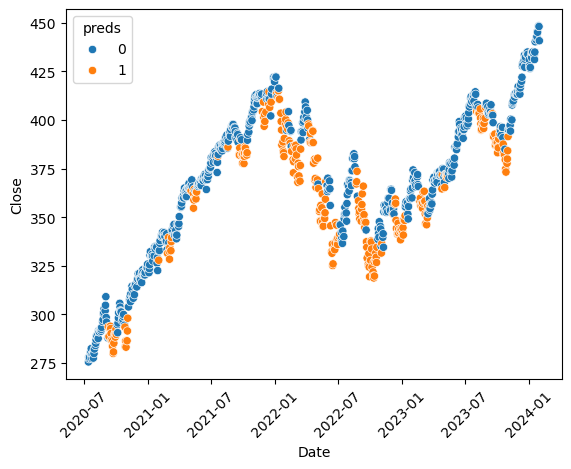

In [59]:
fig, ax=plt.subplots()
sns.scatterplot(x='Date',y='Close',hue='preds',ax=ax,data=test)
ax.tick_params(rotation=45,axis='x')
plt.show()

In [209]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
import xgboost as xgb



# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Create and train the XGBoost classifier
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, max_depth=5)
model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Print the classification report and accuracy
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nRecall:", recall_score(y_test, y_pred))
print("\nF1 Score:", f1_score(y_test, y_pred))





/Users/johnprichard/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:13:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report:
              precision    recall  f1-score   support

       False       0.91      0.91      0.91       583
        True       0.83      0.84      0.83       311

    accuracy                           0.88       894
   macro avg       0.87      0.87      0.87       894
weighted avg       0.88      0.88      0.88       894


Accuracy: 0.8847874720357942

Recall: 0.8360128617363344

F1 Score: 0.8346709470304976


/var/folders/y_/zdr3xmx13qz3pq6ct9kglm7h0000gn/T/ipykernel_71290/3727551369.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['preds']=model.predict(test[features])


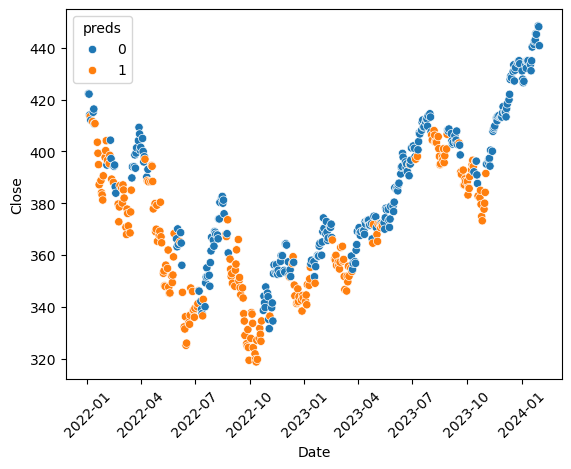

In [164]:
test['preds']=model.predict(test[features])
data=test[test['Date'].dt.year>=2022]
fig, ax=plt.subplots()
sns.scatterplot(x='Date',y='Close',hue='preds',ax=ax,data=data)
ax.tick_params(rotation=45,axis='x')
plt.show()

In [229]:
joined.head(20)

,level_0,index,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,...,CPI_y,UNRATE_pct_change,FEDFUNDS_pct_change,CPI_pct_change,UNRATE_pct_change_lag1,UNRATE_pct_change_lag2,FEDFUNDS_pct_change_lag1,FEDFUNDS_pct_change_lag2,CPI_pct_change_lag1,CPI_pct_change_lag2
62,62,62,2012-04-02,102.952300,104.055866,102.744372,103.783974,374700,0.0,0.0,...,229.187,0.0,7.692308,0.166079,-1.204819,0.0,30.0,25.0,0.209347,0.213745
63,63,63,2012-04-03,103.592025,103.815950,102.760351,103.384109,333850,0.0,0.0,...,229.187,0.0,7.692308,0.166079,-1.204819,0.0,30.0,25.0,0.209347,0.213745
64,64,64,2012-04-04,102.568416,102.664387,101.992644,102.296524,383000,0.0,0.0,...,229.187,0.0,7.692308,0.166079,-1.204819,0.0,30.0,25.0,0.209347,0.213745
65,65,65,2012-04-05,101.976629,102.584396,101.880670,102.264519,722350,0.0,0.0,...,229.187,0.0,7.692308,0.166079,-1.204819,0.0,30.0,25.0,0.209347,0.213745
66,66,66,2012-04-09,101.001020,101.544810,100.873066,101.128967,474850,0.0,0.0,...,229.187,0.0,7.692308,0.166079,-1.204819,0.0,30.0,25.0,0.209347,0.213745
67,67,67,2012-04-10,100.937031,101.208923,99.337648,99.369637,392650,0.0,0.0,...,229.187,0.0,7.692308,0.166079,-1.204819,0.0,30.0,25.0,0.209347,0.213745
68,68,68,2012-04-11,100.489228,100.617175,100.073385,100.185341,172850,0.0,0.0,...,229.187,0.0,7.692308,0.166079,-1.204819,0.0,30.0,25.0,0.209347,0.213745
69,69,69,2012-04-12,100.297292,101.608786,100.281301,101.560806,105550,0.0,0.0,...,229.187,0.0,7.692308,0.166079,-1.204819,0.0,30.0,25.0,0.209347,0.213745
70,70,70,2012-04-13,101.320894,101.320894,100.249311,100.345276,2416850,0.0,0.0,...,229.187,0.0,7.692308,0.166079,-1.204819,0.0,30.0,25.0,0.209347,0.213745
71,71,71,2012-04-16,100.889052,101.001008,99.913428,100.233299,826850,0.0,0.0,...,229.187,0.0,7.692308,0.166079,-1.204819,0.0,30.0,25.0,0.209347,0.213745


In [848]:
for column in X_train.columns:
    print(column)

Close_pct_change_lag1
Close_pct_change_lag2
Close_pct_change_lag3
Close_pct_change_lag4
Close_pct_change_lag5
Close_pct_change_lag6
Close_pct_change_lag7
Close_pct_change_lag8
Close_pct_change_lag9
Close_pct_change_lag10
Close_pct_change_lag11
Close_pct_change_lag12
Close_pct_change_lag13
Close_pct_change_lag14
Close_pct_change_lag15
Close_pct_change_lag16
Close_pct_change_lag17
Close_pct_change_lag18
Close_pct_change_lag19
Close_pct_change_lag20
Volume_pct_change_lag1
Volume_pct_change_lag2
Volume_pct_change_lag3
Volume_pct_change_lag4
Volume_pct_change_lag5
Volume_pct_change_lag6
Volume_pct_change_lag7
Volume_pct_change_lag8
Volume_pct_change_lag9
Volume_pct_change_lag10
Volume_pct_change_lag11
Volume_pct_change_lag12
Volume_pct_change_lag13
Volume_pct_change_lag14
Volume_pct_change_lag15
Volume_pct_change_lag16
Volume_pct_change_lag17
Volume_pct_change_lag18
Volume_pct_change_lag19
Volume_pct_change_lag20
Adj Close_xly_pct_change_lag1
Adj Close_xly_pct_change_lag2
Adj Close_xly_pct_

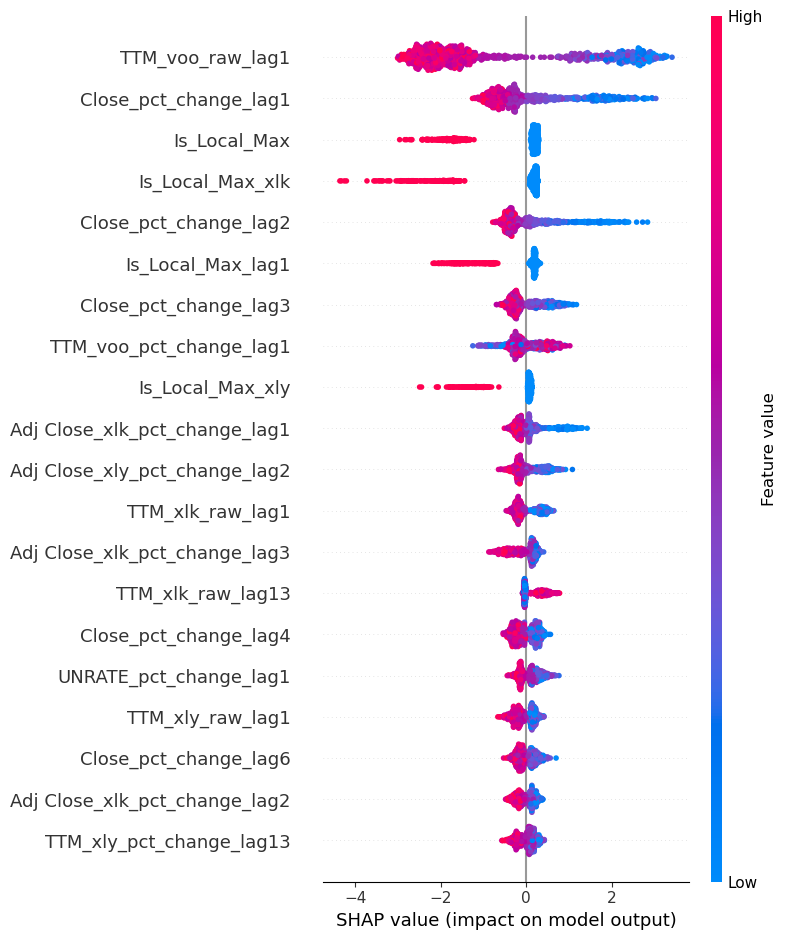

In [61]:
import pandas as pd
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split



# Calculate SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# Visualize the SHAP values
shap.initjs()  # Initialize JavaScript visualization in Jupyter Notebook

# Summary plot
shap.summary_plot(shap_values, X_test)

# Force plot for a single prediction
shap.plots.force(shap_values[0])  # Change the index for different predictions


In [211]:
data['isDecreasing_Predicted']=model.predict(data[features])


In [168]:
data[['Date','isDecreasing_Predicted']].to_csv(f'isDecreasing_Data.csv',index=False)

In [170]:
data['isDecreasing_Predicted'].value_counts()

isDecreasing_Predicted
0    285
1    237
Name: count, dtype: int64

In [217]:

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train2)

# Create and train the XGBoost classifier
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42,max_depth=6)
model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Print the classification report and accuracy
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nRecall:", recall_score(y_test, y_pred))
print("\nF1 Score:", f1_score(y_test, y_pred))

/Users/johnprichard/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:15:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report:
              precision    recall  f1-score   support

       False       0.88      0.18      0.30       583
        True       0.38      0.95      0.55       311

    accuracy                           0.45       894
   macro avg       0.63      0.57      0.42       894
weighted avg       0.71      0.45      0.39       894


Accuracy: 0.44966442953020136

Recall: 0.954983922829582

F1 Score: 0.5469613259668509


In [173]:
data[['Date','Predicted_Action']].sample(20)

,Date,Predicted_Action
2895,2023-07-07,0
2521,2022-01-07,1
2685,2022-09-02,1
2866,2023-05-24,1
2629,2022-06-14,1
2986,2023-11-14,1
3005,2023-12-12,1
2551,2022-02-22,1
2720,2022-10-24,1
2596,2022-04-27,1


In [247]:
# Create the XGBoost classifier
model = xgb.XGBClassifier(use_label_encoder=True, eval_metric='logloss', max_depth=6)

# Train the model
model.fit(X_train, y_train2)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print('Recall', recall_score(y_test,y_pred))
print('F1_score', f1_score(y_test,y_pred))
print(classification_report(y_test, y_pred))

/Users/johnprichard/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:36:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.412751677852349
Recall 0.9003215434083601
F1_score 0.5161290322580645
              precision    recall  f1-score   support

       False       0.74      0.15      0.25       583
        True       0.36      0.90      0.52       311

    accuracy                           0.41       894
   macro avg       0.55      0.53      0.38       894
weighted avg       0.61      0.41      0.34       894



In [249]:
test['Predicted_Action1']=y_pred
test['Predicted_Action1'].value_counts()

/var/folders/y_/zdr3xmx13qz3pq6ct9kglm7h0000gn/T/ipykernel_71290/1617572393.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predicted_Action1']=y_pred


Predicted_Action1
1    774
0    120
Name: count, dtype: int64

In [251]:
test['Predicted_Action']=test.apply(lambda x: False if ((x['Predicted_Action1']==0)&(x['isDecreasing'])) else True,axis=1)

/var/folders/y_/zdr3xmx13qz3pq6ct9kglm7h0000gn/T/ipykernel_71290/1140393460.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predicted_Action']=test.apply(lambda x: False if ((x['Predicted_Action1']==0)&(x['isDecreasing'])) else True,axis=1)


In [253]:
test['Predicted_Action'].value_counts()

Predicted_Action
True     863
False     31
Name: count, dtype: int64

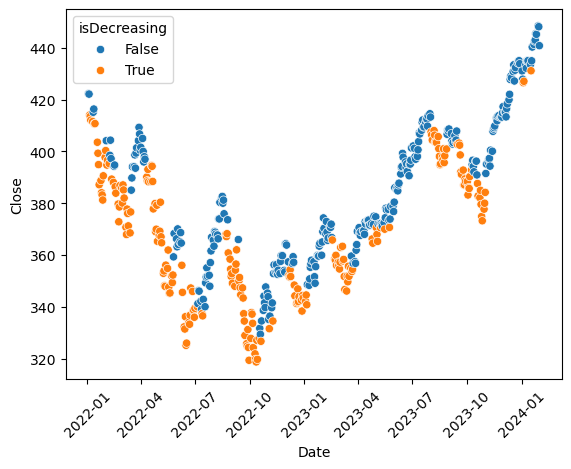

In [261]:
data=test[test['Date'].dt.year>=2022]
fig, ax=plt.subplots()
sns.scatterplot(x='Date',y='Close',hue='isDecreasing',ax=ax,data=data)
ax.tick_params(rotation=45,axis='x')
plt.show()

In [263]:
data[['Date','Predicted_Action','isDecreasing',]].to_csv('Action_Data.csv',index=False)

In [265]:
data['isDecreasing'].value_counts()

isDecreasing
False    292
True     230
Name: count, dtype: int64